In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("./loan_data_updated.csv")
df.head()

,loan_id,applicant_gender,applicant_married,applicant_dependents,applicant_education,applicant_employment,applicant_income,applicant_employment_history,applicant_credit_score,applicant_credit_default,...,co_applicant,co_applicant_income,co_applicant_employment,co_applicant_employment_history,co_applicant_credit_score,co_applicant_credit_default,loan_amount,loan_amount_term,property_area,loan_status
0,LP001003,Male,True,1,Graduate,Salaried,4583,28,329,True,...,False,1508.0,Not Applicable,0,650,False,128.0,360.0,Rural,False
1,LP001005,Male,True,0,Graduate,Self-Employed,3000,28,713,False,...,True,0.0,Self-Employed,3,808,True,66.0,360.0,Urban,True
2,LP001006,Male,True,0,Not Graduate,Salaried,2583,28,751,False,...,False,2358.0,Not Applicable,0,650,False,120.0,360.0,Urban,True
3,LP001008,Male,False,0,Graduate,Salaried,6000,22,689,False,...,False,0.0,Not Applicable,0,650,False,141.0,360.0,Urban,True
4,LP001013,Male,True,0,Not Graduate,Salaried,2333,55,834,False,...,False,1516.0,Not Applicable,0,650,False,95.0,360.0,Urban,True


* loan_id: Identifier for the loan (unique for each row).
* applicant_gender, applicant_married, applicant_dependents, applicant_education, applicant_employment: Demographic and employment information about the applicant.
* applicant_income, applicant_employment_history, applicant_credit_score, applicant_credit_default, applicant_credit_history: Financial and credit history details of the applicant.
* co_applicant, co_applicant_income, co_applicant_employment, co_applicant_employment_history, co_applicant_credit_score, co_applicant_credit_default: Similar details for a co-applicant, if any.
* loan_amount, loan_amount_term: Details about the requested loan.
* property_area: Location type of the property.
* loan_status: Target variable indicating if the loan was approved or not.

In [3]:
df.drop(["loan_id"], axis = 1, inplace= True)

### EDA Exploration

In [4]:
# General Statistics
df.describe()

,applicant_income,applicant_employment_history,applicant_credit_score,applicant_credit_history,co_applicant_income,co_applicant_employment_history,co_applicant_credit_score,loan_amount,loan_amount_term
count,381.000000,381.000000,381.000000,381.00000,381.000000,381.000000,381.000000,381.000000,370.000000
mean,3579.845144,38.671916,699.131234,50.03937,1277.275381,12.044619,670.149606,104.986877,340.864865
std,1419.813818,16.213379,159.319568,10.86283,2340.818114,15.867232,92.921224,28.358464,68.549257
min,150.000000,0.000000,301.000000,5.00000,0.000000,0.000000,402.000000,9.000000,12.000000
25%,2600.000000,27.000000,640.000000,46.00000,0.000000,0.000000,650.000000,90.000000,360.000000
50%,3333.000000,42.000000,736.000000,54.00000,983.000000,0.000000,650.000000,110.000000,360.000000
75%,4288.000000,52.000000,819.000000,58.00000,2016.000000,22.000000,692.000000,127.000000,360.000000
max,9703.000000,60.000000,900.000000,60.00000,33837.000000,48.000000,897.000000,150.000000,480.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   applicant_gender                 376 non-null    object 
 1   applicant_married                381 non-null    bool   
 2   applicant_dependents             373 non-null    object 
 3   applicant_education              381 non-null    object 
 4   applicant_employment             381 non-null    object 
 5   applicant_income                 381 non-null    int64  
 6   applicant_employment_history     381 non-null    int64  
 7   applicant_credit_score           381 non-null    int64  
 8   applicant_credit_default         381 non-null    bool   
 9   applicant_credit_history         381 non-null    int64  
 10  co_applicant                     381 non-null    bool   
 11  co_applicant_income              381 non-null    float64
 12  co_applicant_employmen

In [6]:
categorical_features = [
    'applicant_gender', 'applicant_married', 'applicant_dependents',
    'applicant_education', 'applicant_employment', 'applicant_credit_default',
    'co_applicant', 'co_applicant_employment', 'co_applicant_credit_default',
    'property_area', 'loan_status'
]

numerical_features = [
    'applicant_income', 'applicant_employment_history', 'applicant_credit_score',
    'applicant_credit_history', 'co_applicant_income', 'co_applicant_employment_history',
    'co_applicant_credit_score', 'loan_amount', 'loan_amount_term'
]

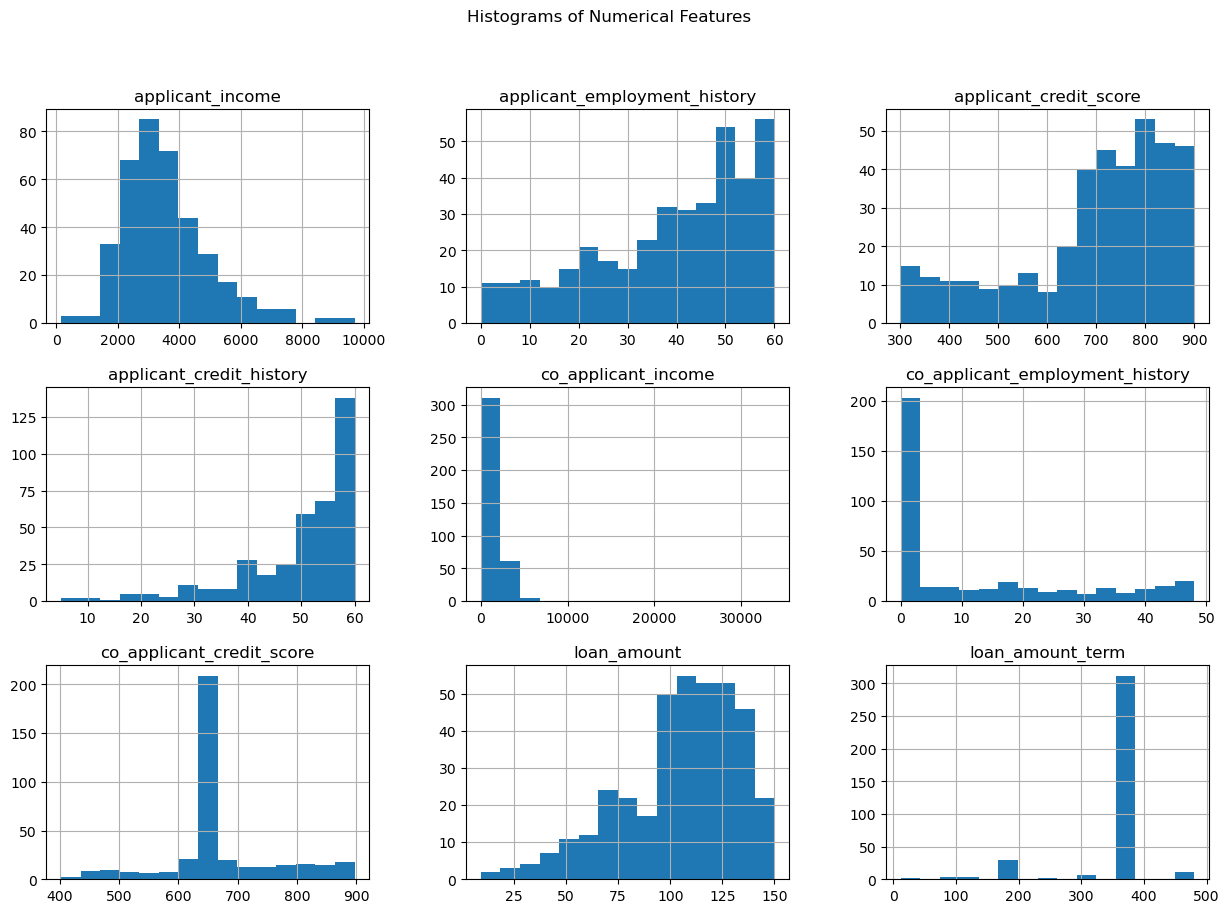

In [7]:
# Histograms for numerical features
df[numerical_features].hist(bins=15, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features')
plt.show()

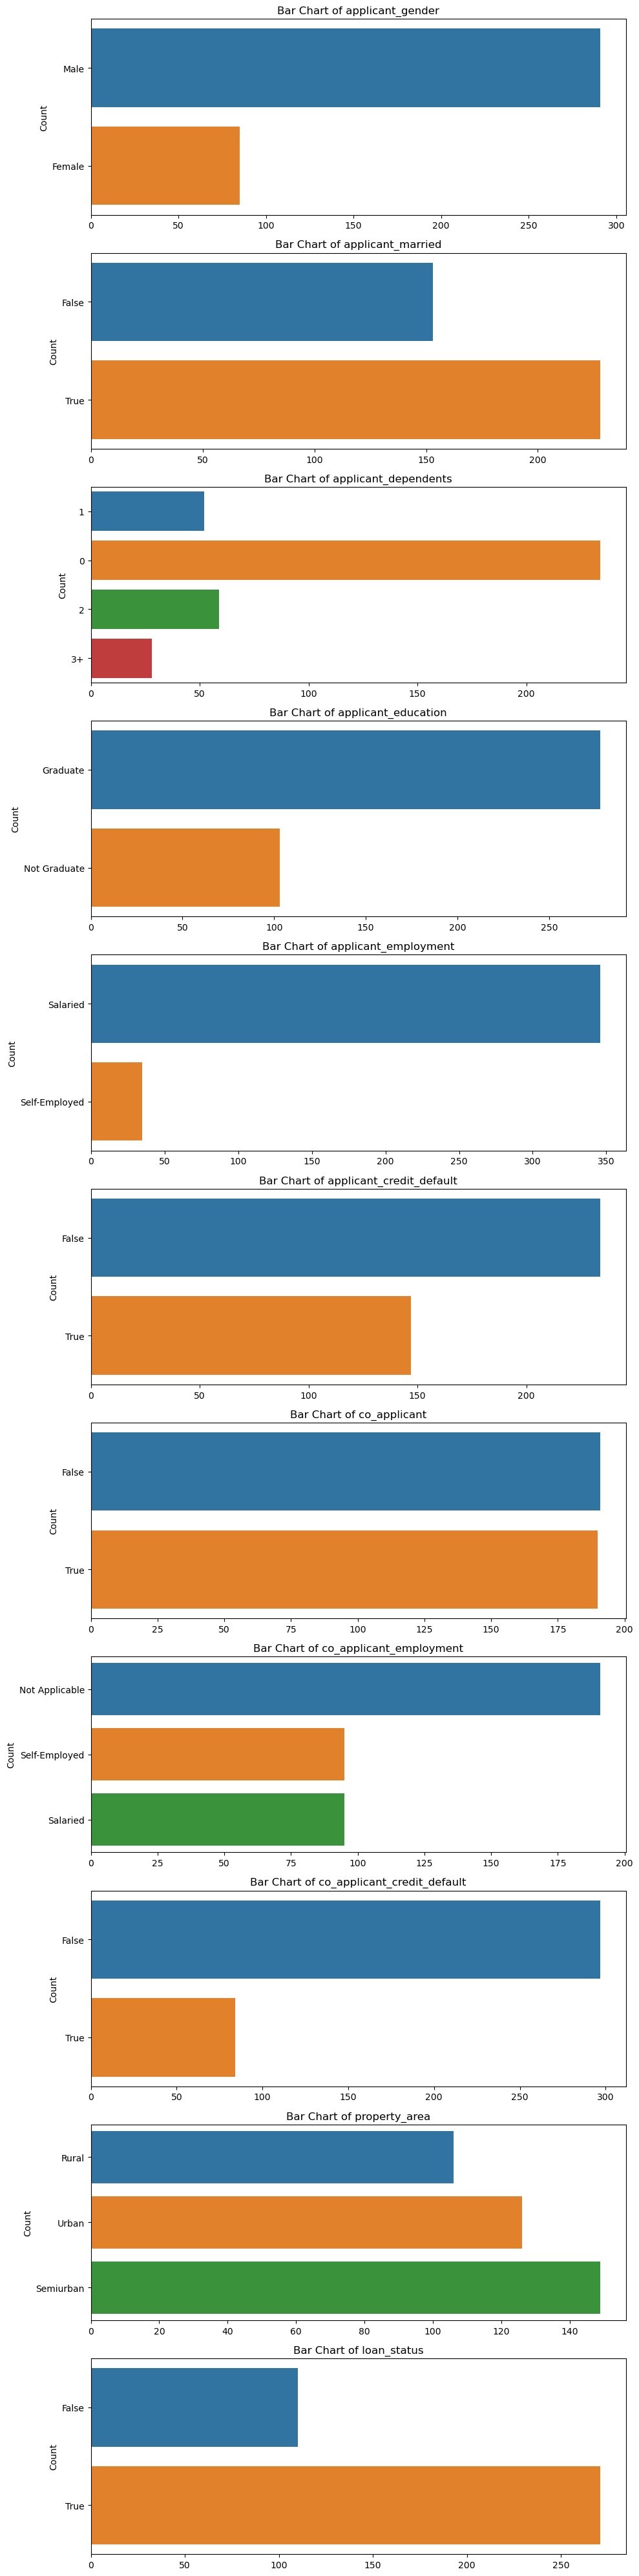

In [8]:
# Bar charts for categorical features
fig, axes = plt.subplots(nrows=len(categorical_features), ncols=1, figsize=(10, 40))
for i, col in enumerate(categorical_features):
    sns.countplot(y=col, data=df, ax=axes[i])
    axes[i].set_title(f'Bar Chart of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

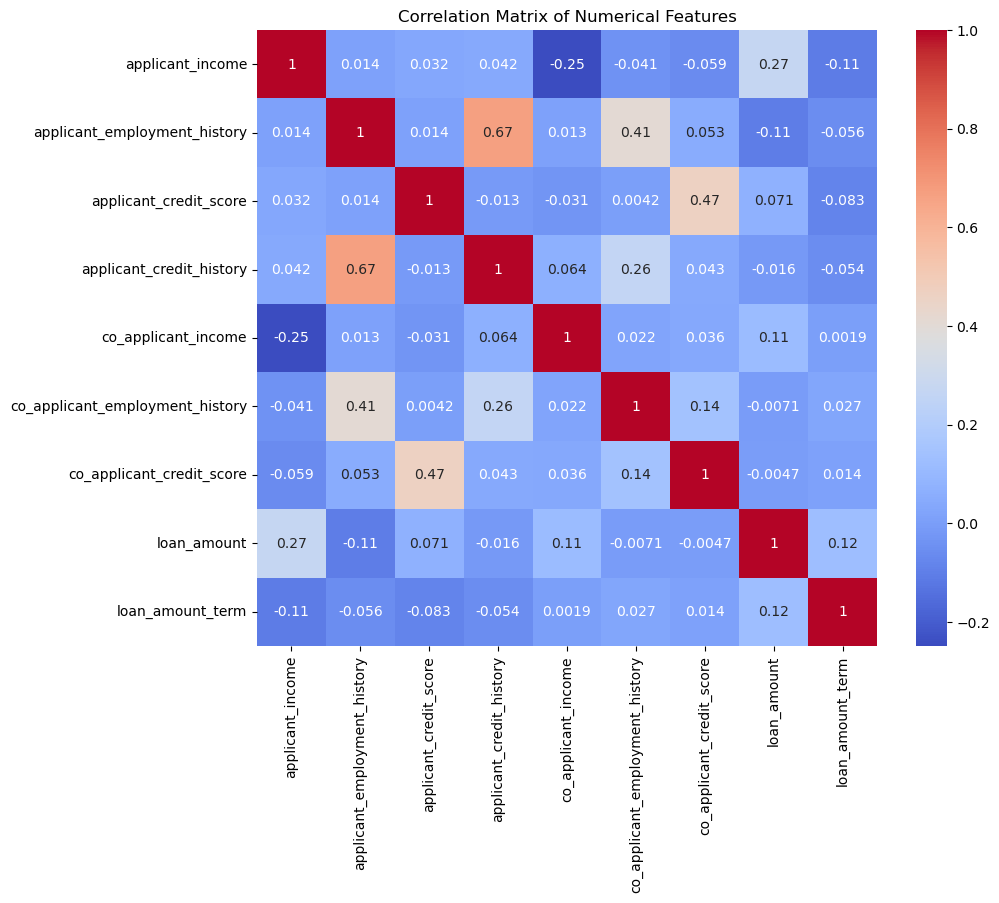

In [9]:
# Correlation matrix
corr_matrix = df[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

* applicant_employment_history and applicant_credit_history show a relatively strong positive correlation (0.68), suggesting that as one's employment history increases, their credit score may also tend to be higher.
* loan_amount has a modest positive correlation (0.27) with applicant_income, which might indicate that people with higher incomes tend to take out larger loans.
* There's a negative correlation (-0.25) between co_applicant_income and applicant_income, indicating that when one has a higher income, the co-applicant might tend to have a lower income, or vice versa.

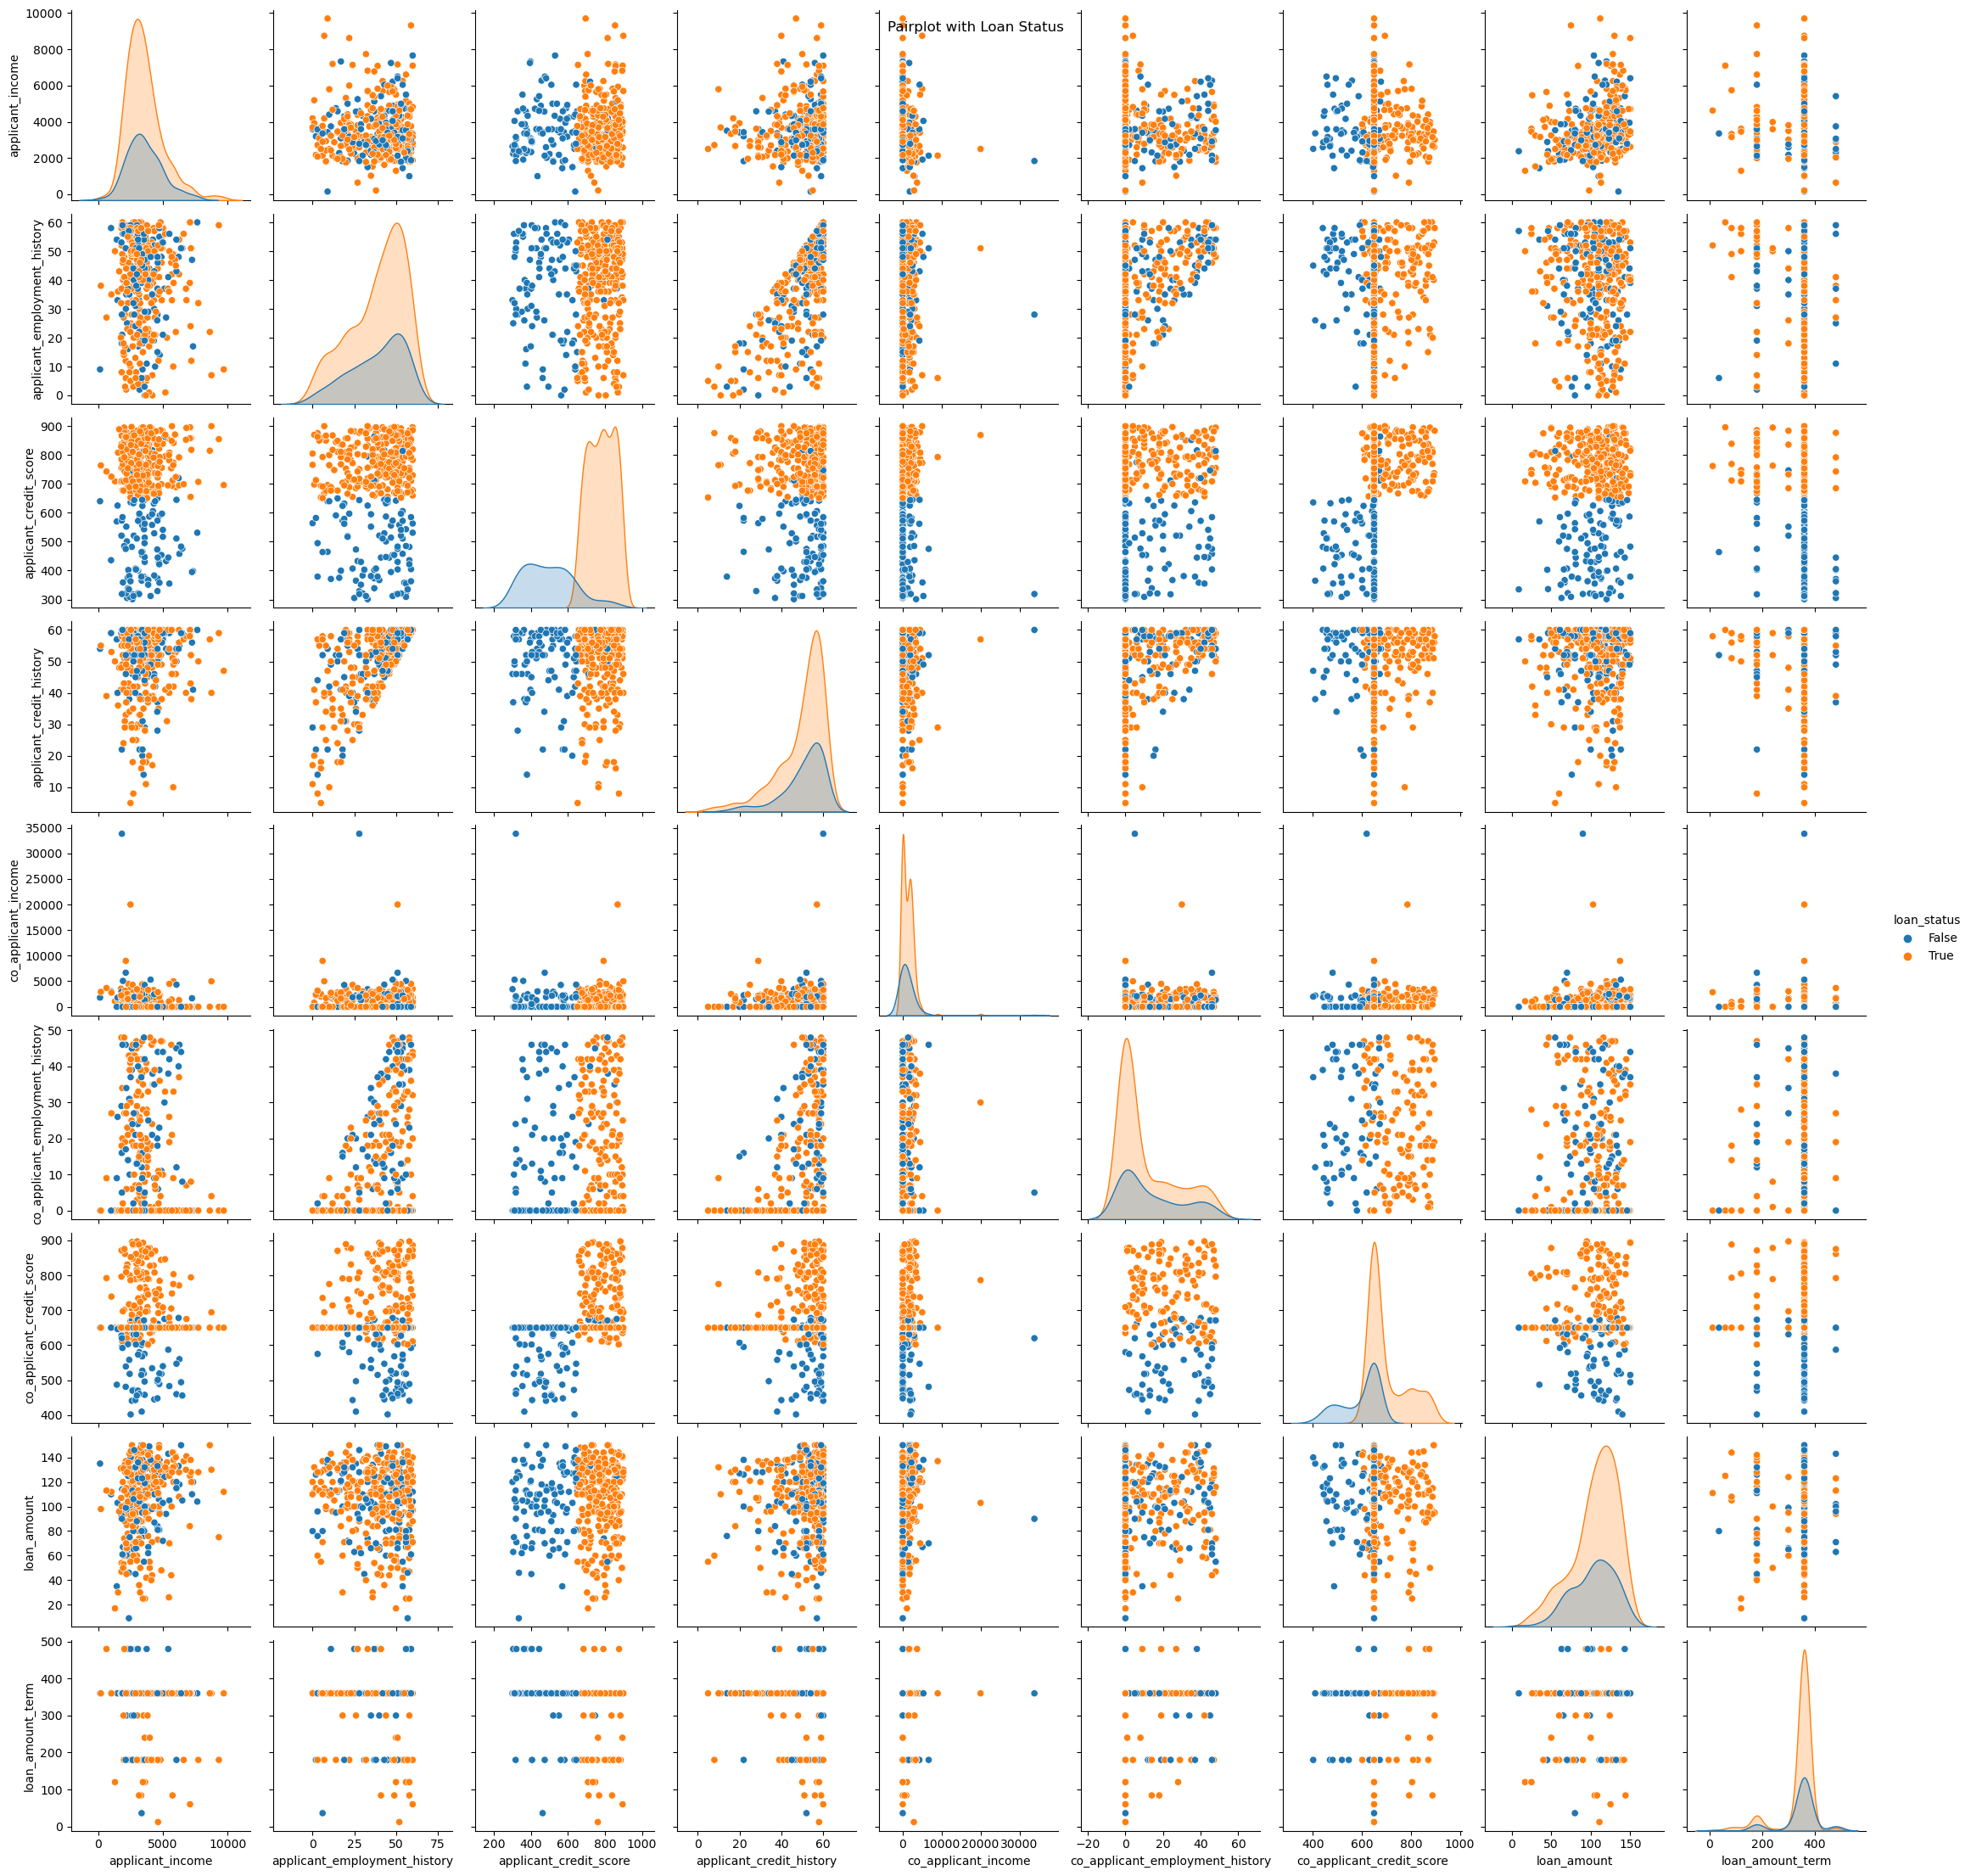

In [10]:
# Pairplot for selected features against the loan status
sns.pairplot(df, vars=numerical_features, hue='loan_status')
plt.suptitle('Pairplot with Loan Status')
plt.show()

* Clusters of points separated by color, indicating a potential interaction between those variables and the loan status.
* Patterns such as upward or downward trends in the scatter plots that might indicate positive or negative correlations.
* Variations in the histograms or density plots, which could suggest that certain values of a variable are more likely to correspond to one loan status category or another.


In [11]:
df['loan_status'].value_counts()

loan_status
True     271
False    110
Name: count, dtype: int64

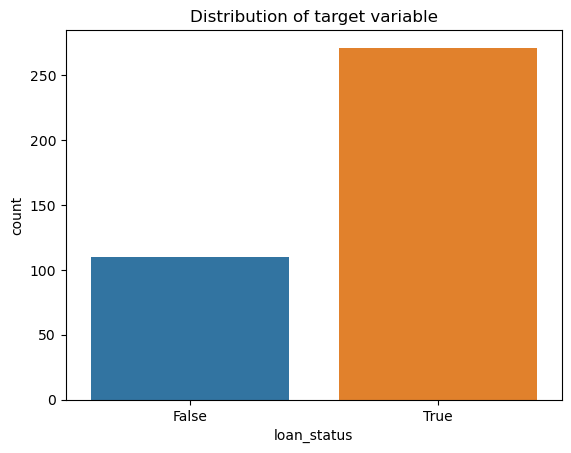

In [12]:
sns.countplot(data = df, x='loan_status')
plt.title("Distribution of target variable")
plt.show()

### Data Preprocessing

In [13]:
# Checking for missing values
print("Missing values per column:")
df.isnull().sum()

Missing values per column:


applicant_gender                    5
applicant_married                   0
applicant_dependents                8
applicant_education                 0
applicant_employment                0
applicant_income                    0
applicant_employment_history        0
applicant_credit_score              0
applicant_credit_default            0
applicant_credit_history            0
co_applicant                        0
co_applicant_income                 0
co_applicant_employment             0
co_applicant_employment_history     0
co_applicant_credit_score           0
co_applicant_credit_default         0
loan_amount                         0
loan_amount_term                   11
property_area                       0
loan_status                         0
dtype: int64

In [14]:
df = df.drop_duplicates().reset_index(drop=True)

In [15]:
df.dropna(inplace=True)

In [16]:
df.columns

Index(['applicant_gender', 'applicant_married', 'applicant_dependents',
       'applicant_education', 'applicant_employment', 'applicant_income',
       'applicant_employment_history', 'applicant_credit_score',
       'applicant_credit_default', 'applicant_credit_history', 'co_applicant',
       'co_applicant_income', 'co_applicant_employment',
       'co_applicant_employment_history', 'co_applicant_credit_score',
       'co_applicant_credit_default', 'loan_amount', 'loan_amount_term',
       'property_area', 'loan_status'],
      dtype='object')

In [17]:
df.head(n=10)

,applicant_gender,applicant_married,applicant_dependents,applicant_education,applicant_employment,applicant_income,applicant_employment_history,applicant_credit_score,applicant_credit_default,applicant_credit_history,co_applicant,co_applicant_income,co_applicant_employment,co_applicant_employment_history,co_applicant_credit_score,co_applicant_credit_default,loan_amount,loan_amount_term,property_area,loan_status
0,Male,True,1,Graduate,Salaried,4583,28,329,True,28,False,1508.0,Not Applicable,0,650,False,128.0,360.0,Rural,False
1,Male,True,0,Graduate,Self-Employed,3000,28,713,False,29,True,0.0,Self-Employed,3,808,True,66.0,360.0,Urban,True
2,Male,True,0,Not Graduate,Salaried,2583,28,751,False,30,False,2358.0,Not Applicable,0,650,False,120.0,360.0,Urban,True
3,Male,False,0,Graduate,Salaried,6000,22,689,False,53,False,0.0,Not Applicable,0,650,False,141.0,360.0,Urban,True
4,Male,True,0,Not Graduate,Salaried,2333,55,834,False,57,False,1516.0,Not Applicable,0,650,False,95.0,360.0,Urban,True
5,Male,True,2,Graduate,Salaried,3200,59,855,False,60,True,700.0,Self-Employed,46,705,True,70.0,360.0,Urban,True
6,Male,True,2,Graduate,Salaried,2500,10,800,False,40,False,1840.0,Not Applicable,0,650,False,109.0,360.0,Urban,True
7,Male,False,0,Graduate,Salaried,1853,21,520,True,55,True,2840.0,Salaried,20,632,False,114.0,360.0,Rural,False
8,Male,True,2,Graduate,Salaried,1299,50,709,False,50,False,1086.0,Not Applicable,0,650,False,17.0,120.0,Urban,True
9,Male,False,0,Graduate,Salaried,4950,51,885,True,58,True,0.0,Salaried,47,697,False,125.0,360.0,Urban,True


In [18]:
df.applicant_gender = df.applicant_gender.apply(lambda x: 1 if str(x).lower() == "male" else 0)
df.applicant_education = df.applicant_education.apply(lambda x: 1 if str(x).lower() == "graduate" else 0)
df.applicant_employment = df.applicant_employment.apply(lambda x: 1 if str(x).lower() == "Salaried" else 0)
df.co_applicant_employment = df.co_applicant_employment.apply(lambda x: 1 if str(x).lower() == "Salaried" else 0)
df.applicant_credit_default = df.applicant_credit_default.apply(lambda x: 1 if x == False else 0)


In [19]:
cols_to_encode = ['applicant_dependents', "property_area"]
df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)
df.head()

,applicant_gender,applicant_married,applicant_education,applicant_employment,applicant_income,applicant_employment_history,applicant_credit_score,applicant_credit_default,applicant_credit_history,co_applicant,...,co_applicant_credit_score,co_applicant_credit_default,loan_amount,loan_amount_term,loan_status,applicant_dependents_1,applicant_dependents_2,applicant_dependents_3+,property_area_Semiurban,property_area_Urban
0,1,True,1,0,4583,28,329,0,28,False,...,650,False,128.0,360.0,False,True,False,False,False,False
1,1,True,1,0,3000,28,713,1,29,True,...,808,True,66.0,360.0,True,False,False,False,False,True
2,1,True,0,0,2583,28,751,1,30,False,...,650,False,120.0,360.0,True,False,False,False,False,True
3,1,False,1,0,6000,22,689,1,53,False,...,650,False,141.0,360.0,True,False,False,False,False,True
4,1,True,0,0,2333,55,834,1,57,False,...,650,False,95.0,360.0,True,False,False,False,False,True


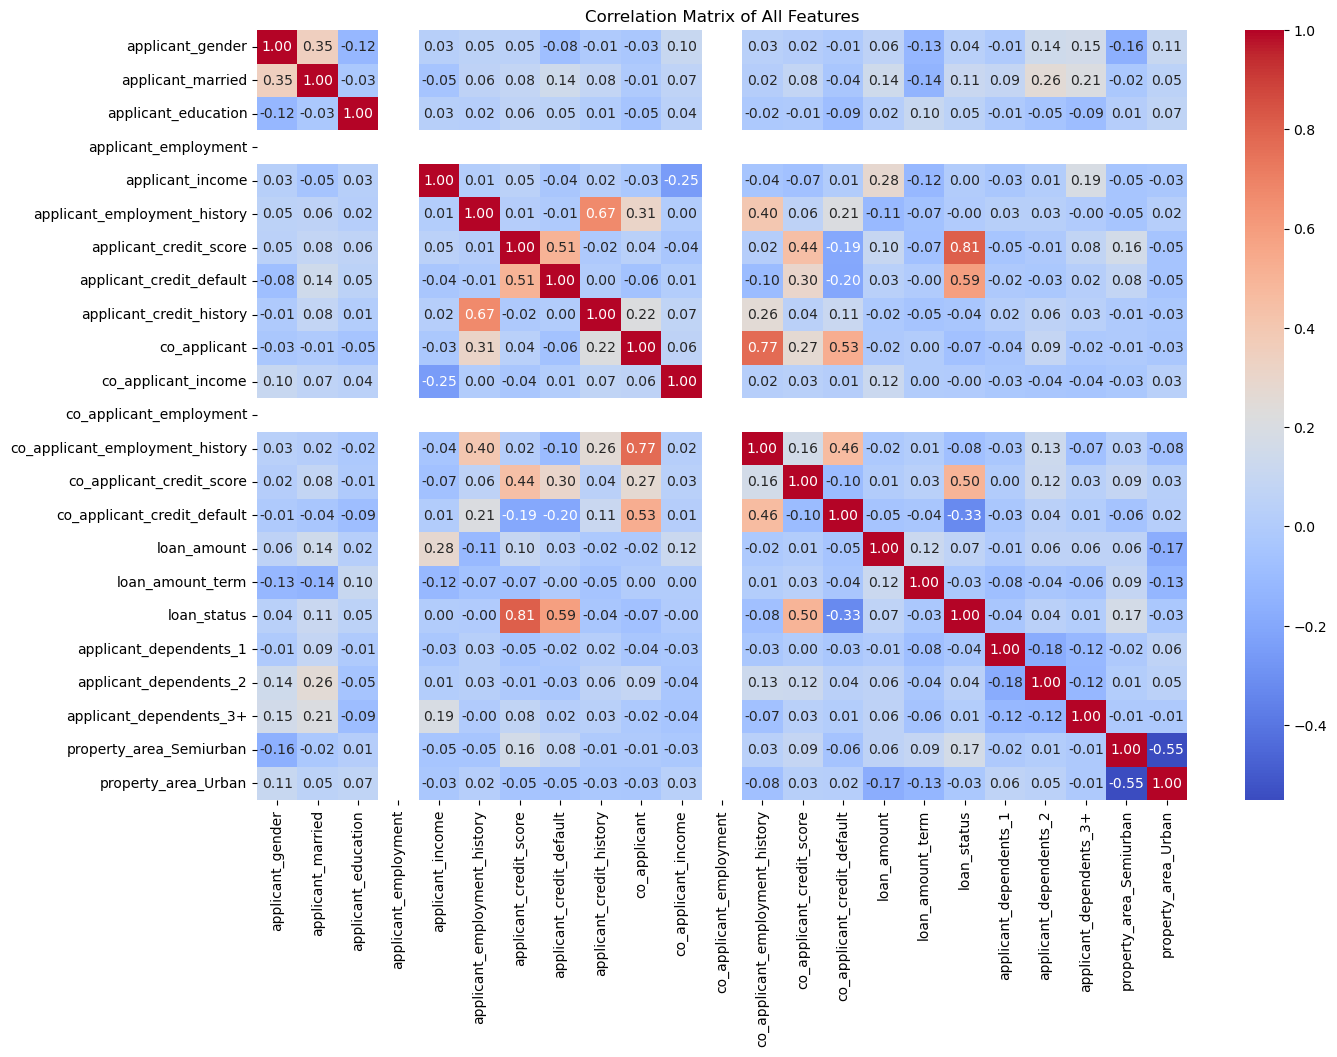

In [20]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Use seaborn to create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of All Features')
plt.show()

* Diagonal: The diagonal from the top-left to the bottom-right shows a perfect correlation of 1, as this is each variable correlated with itself.
* Positive Correlations: Light to dark red squares indicate variables that have a positive correlation. For example, if applicant_income has a red square in the column under loan_amount, it would indicate that higher applicant income is generally associated with larger loan amounts.
* Negative Correlations: Light to dark blue squares represent negative correlations. For instance, if there is a dark blue square at the intersection of applicant_income and co_applicant_income, it could indicate that generally when one is high, the other is low.
* Close to Zero: White or lighter colored squares suggest no significant correlation. This means the variables don't have a strong linear relationship.


### Scenerio 1:

* Income should be greater than or equal to 2000.
* Credit Score should be greater than or equal to 650.
* Credit History should be greater than or equal to 30.
* Employment History should be greater than or equal to 18.
* Credit Default should be False.

In [21]:
#making a copy of the dataframe
df1 = df.copy()

In [22]:
# function for loan approval
def custom_loan_approval_1(row):
    if (row['applicant_income'] >= 2000 and
        row['applicant_credit_score'] >= 650 and
        row['applicant_credit_history'] >= 30 and
        row['applicant_employment_history'] >= 18 and
        not row['applicant_credit_default']):
        return True
    else:
        return False

def process_loan_application(row):
    if custom_loan_approval_1(row):
        return "Approved"
    else:
        return "Rejected"
        
# Apply the function to each row in the DataFrame
df1['custom_loan_status'] = df1.apply(process_loan_application, axis=1)

# Display the result
df1[
    ['applicant_income', 'applicant_credit_score', 'applicant_credit_history',  'applicant_employment_history', 'applicant_credit_default', 'custom_loan_status']
].sample(n=20)

,applicant_income,applicant_credit_score,applicant_credit_history,applicant_employment_history,applicant_credit_default,custom_loan_status
254,2889,403,45,31,0,Rejected
215,2378,336,59,57,1,Rejected
252,3902,704,55,48,0,Approved
324,2130,475,52,51,0,Rejected
3,6000,689,53,22,1,Rejected
110,1916,359,59,56,0,Rejected
18,4226,668,39,39,1,Rejected
255,2755,521,59,40,0,Rejected
114,2383,865,60,58,1,Rejected
86,4583,373,37,37,1,Rejected


In [23]:
df1.custom_loan_status.value_counts()

custom_loan_status
Rejected    308
Approved     50
Name: count, dtype: int64

In [24]:
# Fature and target Variables
X = df1.drop(['loan_status', 'custom_loan_status'], axis=1)  
y = df1['custom_loan_status'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
#Model Training
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [27]:
#Prediction
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9861111111111112
Classification Report:
               precision    recall  f1-score   support

    Approved       1.00      0.88      0.93         8
    Rejected       0.98      1.00      0.99        64

    accuracy                           0.99        72
   macro avg       0.99      0.94      0.96        72
weighted avg       0.99      0.99      0.99        72



In [28]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
print(importances)

                          Attribute  Importance
7          applicant_credit_default    3.499653
9                      co_applicant    0.219538
1                 applicant_married    0.177050
10              co_applicant_income    0.137240
14      co_applicant_credit_default    0.110301
11          co_applicant_employment    0.000000
3              applicant_employment    0.000000
19          applicant_dependents_3+   -0.003750
16                 loan_amount_term   -0.006978
20          property_area_Semiurban   -0.063140
21              property_area_Urban   -0.134858
2               applicant_education   -0.223597
18           applicant_dependents_2   -0.226565
17           applicant_dependents_1   -0.229068
0                  applicant_gender   -0.251622
12  co_applicant_employment_history   -0.256143
15                      loan_amount   -0.312576
5      applicant_employment_history   -0.431317
4                  applicant_income   -0.440478
8          applicant_credit_history   -0

In [29]:
# Using a random forest for potentially better performance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RF Classification Report:\n", classification_report(y_test, y_pred_rf))

RF Accuracy: 0.9861111111111112
RF Classification Report:
               precision    recall  f1-score   support

    Approved       1.00      0.88      0.93         8
    Rejected       0.98      1.00      0.99        64

    accuracy                           0.99        72
   macro avg       0.99      0.94      0.96        72
weighted avg       0.99      0.99      0.99        72



### Scenerio 2:

* Applicant credit score < 650.
* Applicant credit history < 10.
* Whether Co-applicant - Yes/No.
* If Yes, Co-applicant Credit Score >= 650.
* Co-applicant Credit Default = False
* Based on the condition, Approval/ Rejection.



In [30]:
#making a copy of the dataframe
df2 = df.copy()
df2

,applicant_gender,applicant_married,applicant_education,applicant_employment,applicant_income,applicant_employment_history,applicant_credit_score,applicant_credit_default,applicant_credit_history,co_applicant,...,co_applicant_credit_score,co_applicant_credit_default,loan_amount,loan_amount_term,loan_status,applicant_dependents_1,applicant_dependents_2,applicant_dependents_3+,property_area_Semiurban,property_area_Urban
0,1,True,1,0,4583,28,329,0,28,False,...,650,False,128.0,360.0,False,True,False,False,False,False
1,1,True,1,0,3000,28,713,1,29,True,...,808,True,66.0,360.0,True,False,False,False,False,True
2,1,True,0,0,2583,28,751,1,30,False,...,650,False,120.0,360.0,True,False,False,False,False,True
3,1,False,1,0,6000,22,689,1,53,False,...,650,False,141.0,360.0,True,False,False,False,False,True
4,1,True,0,0,2333,55,834,1,57,False,...,650,False,95.0,360.0,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,1,True,1,0,5703,33,900,1,46,False,...,650,False,128.0,360.0,True,False,False,True,False,True
377,1,True,1,0,3232,46,882,1,54,True,...,764,False,108.0,360.0,True,False,False,False,False,False
378,0,False,1,0,2900,6,691,1,57,False,...,650,False,71.0,360.0,True,False,False,False,False,False
379,1,True,1,0,4106,32,875,1,52,False,...,650,False,40.0,180.0,True,False,False,True,False,False


In [31]:
def custom_loan_approval_2(row):
    # Criteria for approving the loan
    if row['applicant_credit_score'] < 650 or row['applicant_credit_history'] < 10:
        if row['co_applicant'] and row['co_applicant_credit_score'] >= 650 and not row['co_applicant_credit_default']: 
            return True
        else:
            return False
    else:
        return True

def process_loan_application(row):
    if custom_loan_approval_2(row):
        return "Approved"
    else:
        return "Rejected"

In [32]:
# Apply the function to the DataFrame
df2['custom_loan_status'] = df2.apply(process_loan_application, axis=1)

# Display the results
df2[['applicant_credit_score', 'applicant_credit_history', 'co_applicant', 
               'co_applicant_employment', 'co_applicant_credit_score', 
               'co_applicant_credit_default', 
               'custom_loan_status']].sample(10)

,applicant_credit_score,applicant_credit_history,co_applicant,co_applicant_employment,co_applicant_credit_score,co_applicant_credit_default,custom_loan_status
201,675,52,True,0,806,False,Approved
256,869,57,True,0,786,False,Approved
82,895,51,True,0,701,False,Approved
348,868,50,True,0,713,False,Approved
79,793,29,False,0,650,False,Approved
153,696,47,False,0,650,False,Approved
8,709,50,False,0,650,False,Approved
247,845,43,False,0,650,False,Approved
172,810,40,True,0,889,False,Approved
157,465,22,False,0,650,False,Rejected


In [33]:
df2.custom_loan_status.value_counts()

custom_loan_status
Approved    268
Rejected     90
Name: count, dtype: int64

In [34]:
# Fature and target Variables
X = df2.drop(['loan_status', 'custom_loan_status'], axis=1)  
y = df2['custom_loan_status'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
#Model Training
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [37]:
#Prediction
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9305555555555556
Classification Report:
               precision    recall  f1-score   support

    Approved       0.93      0.98      0.96        58
    Rejected       0.91      0.71      0.80        14

    accuracy                           0.93        72
   macro avg       0.92      0.85      0.88        72
weighted avg       0.93      0.93      0.93        72



In [38]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
print(importances)

                          Attribute  Importance
14      co_applicant_credit_default    0.493383
19          applicant_dependents_3+    0.251480
18           applicant_dependents_2    0.123049
0                  applicant_gender    0.032630
1                 applicant_married    0.004678
11          co_applicant_employment    0.000000
3              applicant_employment    0.000000
16                 loan_amount_term   -0.006831
12  co_applicant_employment_history   -0.034552
2               applicant_education   -0.057184
9                      co_applicant   -0.077549
21              property_area_Urban   -0.129102
5      applicant_employment_history   -0.158319
15                      loan_amount   -0.174147
20          property_area_Semiurban   -0.181122
10              co_applicant_income   -0.213014
17           applicant_dependents_1   -0.250038
4                  applicant_income   -0.284915
8          applicant_credit_history   -0.552651
7          applicant_credit_default   -1

In [39]:
# Using a random forest for potentially better performance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RF Classification Report:\n", classification_report(y_test, y_pred_rf))

RF Accuracy: 0.9722222222222222
RF Classification Report:
               precision    recall  f1-score   support

    Approved       0.98      0.98      0.98        58
    Rejected       0.93      0.93      0.93        14

    accuracy                           0.97        72
   macro avg       0.96      0.96      0.96        72
weighted avg       0.97      0.97      0.97        72



### Scenerio 3:


* Applicant Income >= 2000.
* Applicant credit score >= 650.
* Applicant credit history >= 30.
* Applicant employment history >= 18.
* Applicant credit default = False.
* Property Type= Semi-Urban/Urban.
* Based on the condition, Approval/ Rejection.


In [40]:
df3 = df.copy()

In [41]:
def custom_loan_approval_3(row):
    if (row['applicant_income'] >= 2000 and
        row['applicant_credit_score'] >= 650 and
        row['applicant_credit_history'] >= 30 and
        row['applicant_employment_history'] >= 18 and
        not row['applicant_credit_default'] and
        (row['property_area_Semiurban'] == 1 or row['property_area_Urban'] == 1)):
        return True
    else:
        return False




def process_loan_application(row):
    if custom_loan_approval_3(row):
        return "Approved"
    else:
        return "Rejected"

In [42]:
# Apply the function to the DataFrame
df3['custom_loan_status'] = df3.apply(process_loan_application, axis=1)

# Display the results
df3[['applicant_credit_score', 'applicant_credit_history', 'co_applicant', 
               'co_applicant_employment', 'co_applicant_credit_score', 
               'co_applicant_credit_default', 
               'custom_loan_status']].sample(10)

,applicant_credit_score,applicant_credit_history,co_applicant,co_applicant_employment,co_applicant_credit_score,co_applicant_credit_default,custom_loan_status
57,793,54,False,0,650,False,Rejected
239,859,16,False,0,650,False,Rejected
186,737,56,True,0,731,False,Rejected
373,875,60,True,0,602,False,Rejected
72,398,41,False,0,650,False,Rejected
91,808,36,False,0,650,False,Rejected
268,867,55,False,0,650,False,Rejected
164,795,59,True,0,846,True,Rejected
331,849,60,False,0,650,False,Rejected
138,793,57,True,0,833,False,Rejected


In [43]:
df3.custom_loan_status.value_counts()

custom_loan_status
Rejected    320
Approved     38
Name: count, dtype: int64

In [44]:
# Fature and target Variables
X = df3.drop(['loan_status', 'custom_loan_status'], axis=1)  
y = df3['custom_loan_status'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
#Model Training
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [47]:
#Prediction
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9861111111111112
Classification Report:
               precision    recall  f1-score   support

    Approved       1.00      0.80      0.89         5
    Rejected       0.99      1.00      0.99        67

    accuracy                           0.99        72
   macro avg       0.99      0.90      0.94        72
weighted avg       0.99      0.99      0.99        72



In [48]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
print(importances)

                          Attribute  Importance
7          applicant_credit_default    3.014064
9                      co_applicant    0.137184
10              co_applicant_income    0.091336
14      co_applicant_credit_default    0.071455
1                 applicant_married    0.045248
16                 loan_amount_term    0.000726
11          co_applicant_employment    0.000000
3              applicant_employment    0.000000
15                      loan_amount   -0.119615
18           applicant_dependents_2   -0.120495
19          applicant_dependents_3+   -0.143718
0                  applicant_gender   -0.157817
5      applicant_employment_history   -0.189704
12  co_applicant_employment_history   -0.205101
17           applicant_dependents_1   -0.260911
2               applicant_education   -0.277403
8          applicant_credit_history   -0.326601
4                  applicant_income   -0.348297
13        co_applicant_credit_score   -0.718366
21              property_area_Urban   -1

In [49]:
# Using a random forest for potentially better performance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RF Classification Report:\n", classification_report(y_test, y_pred_rf))

RF Accuracy: 0.9583333333333334
RF Classification Report:
               precision    recall  f1-score   support

    Approved       0.75      0.60      0.67         5
    Rejected       0.97      0.99      0.98        67

    accuracy                           0.96        72
   macro avg       0.86      0.79      0.82        72
weighted avg       0.96      0.96      0.96        72



### Scenario 4

* Applicant Income >= 3000.
* Loan Amount <= 80000.
* Applicant credit score >= 700.
* Applicant credit history >= 36.
* Whether Co-applicant - Yes/No.
* If Yes, Co-applicant Credit Score >= 680.
* Co-applicant Credit Default = False
* Based on the condition, Approval/ Rejection.


In [50]:
df4 = df.copy()

In [51]:
def custom_loan_approval_4(row):
    # Custom criteria for loan approval
    if row['applicant_income'] >= 3000 and row['loan_amount'] <= 80000:
        if row['applicant_credit_score'] >= 700 or row['applicant_credit_history'] >= 36:
            return True
        else:
            if row['co_applicant'] and row['co_applicant_credit_score'] >= 680 and not row['co_applicant_credit_default']:
                return True
            else:
                return False
    else:
        return False


def process_loan_application(row):
    if custom_loan_approval_4(row):
        return "Approved"
    else:
        return "Rejected"

In [52]:
# Apply the function to the DataFrame
df4['custom_loan_status'] = df4.apply(process_loan_application, axis=1)

# Display the results
df4[['applicant_credit_score', 'applicant_credit_history', 'co_applicant', 
               'co_applicant_employment', 'co_applicant_credit_score', 
               'co_applicant_credit_default', 
               'custom_loan_status']].sample(10)

,applicant_credit_score,applicant_credit_history,co_applicant,co_applicant_employment,co_applicant_credit_score,co_applicant_credit_default,custom_loan_status
367,644,52,False,0,650,False,Rejected
287,836,41,False,0,650,False,Rejected
286,339,59,True,0,603,True,Rejected
377,882,54,True,0,764,False,Approved
183,640,42,False,0,650,False,Approved
170,737,56,True,0,895,True,Rejected
178,862,54,True,0,620,False,Approved
344,785,56,False,0,650,False,Approved
209,671,58,True,0,658,True,Rejected
235,900,40,True,0,694,False,Approved


In [53]:
df4.custom_loan_status.value_counts()

custom_loan_status
Approved    212
Rejected    146
Name: count, dtype: int64

In [54]:
# Fature and target Variables
X = df4.drop(['loan_status', 'custom_loan_status'], axis=1)  
y = df4['custom_loan_status'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [56]:
#Model Training
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [57]:
#Prediction
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9305555555555556
Classification Report:
               precision    recall  f1-score   support

    Approved       0.95      0.92      0.94        39
    Rejected       0.91      0.94      0.93        33

    accuracy                           0.93        72
   macro avg       0.93      0.93      0.93        72
weighted avg       0.93      0.93      0.93        72



In [58]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
print(importances)

                          Attribute  Importance
12  co_applicant_employment_history    0.533356
7          applicant_credit_default    0.286309
10              co_applicant_income    0.267981
5      applicant_employment_history    0.219028
20          property_area_Semiurban    0.207875
16                 loan_amount_term    0.115055
19          applicant_dependents_3+    0.037269
0                  applicant_gender    0.027580
17           applicant_dependents_1    0.006143
2               applicant_education    0.002315
18           applicant_dependents_2    0.000379
11          co_applicant_employment    0.000000
3              applicant_employment    0.000000
14      co_applicant_credit_default   -0.020854
21              property_area_Urban   -0.099631
15                      loan_amount   -0.118669
13        co_applicant_credit_score   -0.197246
1                 applicant_married   -0.236230
9                      co_applicant   -0.479520
6            applicant_credit_score   -0

In [59]:
# Using a random forest for potentially better performance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RF Classification Report:\n", classification_report(y_test, y_pred_rf))

RF Accuracy: 0.9861111111111112
RF Classification Report:
               precision    recall  f1-score   support

    Approved       0.97      1.00      0.99        39
    Rejected       1.00      0.97      0.98        33

    accuracy                           0.99        72
   macro avg       0.99      0.98      0.99        72
weighted avg       0.99      0.99      0.99        72

